## Problem Statement https://arxiv.org/pdf/2312.06711v1
# Credits: Nino Antulov-Fantulin, Urban Ulrych

# Black-Scholes PDE for a European Call Option

The value of a European call option \( V(S, t) \), where \( S \) is the underlying asset price and \( t \) is time, satisfies the following partial differential equation (PDE):

$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0,
$$

where:
- \( \sigma \) is the volatility of the underlying asset,
- \( r \) is the risk-free interest rate,
- \( T \) is the time to maturity, and
- \( K \) is the strike price.

## Terminal Condition
At maturity (\( t = T \)), the value of the option is given by its payoff:

$$
V(S, T) = \max(S - K, 0).
$$

## Boundary Conditions
The boundary conditions for the PDE are:

1. As \( S \to 0 \), the call option becomes worthless:
   $$
   V(0, t) = 0, \quad \text{for all } 0 \leq t \leq T.
   $$

2. As \( S \to \infty \), the call option behaves like the underlying asset minus the discounted strike price:
   $$
   \lim_{S \to \infty} V(S, t) = S - K e^{-r(T - t)}.
   $$



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import numpy as np

In [2]:
device

device(type='cpu')

In [3]:
# We consider Net as our solution 
# notation u(x,t):=v(x,t), x:=s.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.hidden_layer5 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        output = F.softplus(self.output_layer(layer5_out))
        #output = torch.relu(self.output_layer(layer5_out))
        #output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output

In [4]:
r = 4.2 / 100
sigma = 22 / 100
# https://digitalcommons.liu.edu/cgi/viewcontent.cgi?article=1074&context=post_honors_theses 

In [5]:
r, sigma

(0.042, 0.22)

In [6]:
## PDE as loss function. Thus would use the network which we call as u_theta
def f(x,t, net):
    # r - risk free rate, sigma - volatility 
    u = net(x,t) # the dependent variable u is given by the network based on independent variables x,t
    ## Black-Sholes f = u_t + 1/2*sigma^2*x^2 * u_xx + r*x*u_x - r*u
    #u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    #u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    #u_xx = torch.autograd.grad(u_x, x, create_graph=True)[0]
    
    u_t = torch.autograd.grad(u, t, 
                     create_graph=True,
                     grad_outputs=torch.ones_like(u), 
                     allow_unused=True)[0]
    u_x = torch.autograd.grad(u, x, 
                     create_graph=True,
                     grad_outputs=torch.ones_like(u), 
                     allow_unused=True)[0]
    u_xx = torch.autograd.grad(u_x, x, 
                     create_graph=True,
                     grad_outputs=torch.ones_like(u), 
                     allow_unused=True)[0]
    pde = u_t + 0.5*(sigma**2)*(x**2)*u_xx + r*x*u_x - r*u
    return pde

In [7]:
## Data from Boundary Conditions -- european call option 
#IVP: u(x,T)= max(x-k,0), k - pay off
#BC1: u(0,t) = 0, for all t
#BC2: u(s_max,t) = s_max - k*exp(-r(T-t))

import math
s_max = 40
T = 30/365 #30 days ahead
k = 39 # strike price
bc_points = 1000
t_max = T + 0.01 # to check


def bc_fun(x,t):
    if x==0.0:
        return 0.0
    else:
        #return s_max
        return s_max - k*np.exp(-r*(T-t))
vectorized_bc = np.vectorize(bc_fun)

x_bc1 = np.zeros((bc_points))
t_bc1 = np.linspace(0.0, t_max, bc_points)
u_bc1 = vectorized_bc(x_bc1, t_bc1)

x_bc2 = np.ones((bc_points))*s_max
t_bc2 = np.linspace(0.0, t_max, bc_points)
u_bc2 = vectorized_bc(x_bc2, t_bc2)

ivp_points = 1000
x_ivp = np.linspace(0.0, s_max, ivp_points)
t_ivp = np.ones((ivp_points))*T

def ivp_fun(x,t):
    if abs(t-T)<1e-7:
        if (x-k)>0:
            return x-k
        else:
            return 0.0
    else:
        return np.nan
    
vectorized_ivp = np.vectorize(ivp_fun)
u_ivp = vectorized_ivp(x_ivp, t_ivp)

In [8]:
x_bc2.shape, t_bc2.shape, u_bc2.shape

((1000,), (1000,), (1000,))

In [9]:
from tqdm import *

net = Net()
net = net.to(device)


def to_tensor(x, requires_grad=False):
    x_np = np.asarray(x, dtype=np.float32)
    if x_np.ndim == 0:  # scalar
        return torch.tensor([x_np], dtype=torch.float32, requires_grad=requires_grad, device=device)
    else:  # array
        return torch.tensor(x_np, dtype=torch.float32, requires_grad=requires_grad, device=device)


In [10]:
### (3) Training / Fitting
from torch.optim import lr_scheduler

collocation_points = 10000
iterations = 5000
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)

# Define StepLR scheduler: Decay LR by gamma every step_size epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)

with tqdm(range(iterations), desc="Training", unit="epoch") as epoch_bar:
    for epoch in epoch_bar:
        optimizer.zero_grad() # to make the gradients zero

        # Loss based on boundary conditions 1
        pt_x_bc1 = to_tensor(x_bc1).unsqueeze(1)
        pt_t_bc1 = to_tensor(t_bc1).unsqueeze(1)
        pt_u_bc1 = to_tensor(u_bc1).unsqueeze(1)

        net_bc1_out = net(pt_x_bc1, pt_t_bc1) # output of u(x,t)
        mse_bc1 = mse_cost_function(net_bc1_out, pt_u_bc1)

        # Loss based on boundary conditions 2
        pt_x_bc2 = to_tensor(x_bc2).unsqueeze(1)
        pt_t_bc2 = to_tensor(t_bc2).unsqueeze(1)
        pt_u_bc2 = to_tensor(u_bc2).unsqueeze(1)
        
        net_bc2_out = net(pt_x_bc2, pt_t_bc2) # output of u(x,t)
        mse_bc2 = mse_cost_function(net_bc2_out, pt_u_bc2)

        # loss based on IVP
        pt_x_ivp = to_tensor(x_ivp).unsqueeze(1)
        pt_t_ivp = to_tensor(t_ivp).unsqueeze(1)
        pt_u_ivp = to_tensor(u_ivp).unsqueeze(1)
        
        net_ivp_out = net(pt_x_ivp, pt_t_ivp) # output of u(x,t)
        mse_ivp = mse_cost_function(net_ivp_out, pt_u_ivp)

        # Loss based on PDE
        x_collocation = np.random.uniform(low=0.0, high=s_max, size=(collocation_points,1))
        t_collocation = np.random.uniform(low=0.0, high=t_max, size=(collocation_points,1))
        all_zeros = np.zeros((collocation_points,1))

        pt_x_collocation = to_tensor(x_collocation, requires_grad=True)
        pt_t_collocation = to_tensor(t_collocation, requires_grad=True)
        pt_all_zeros = to_tensor(all_zeros)  # target output


        f_out = f(pt_x_collocation, pt_t_collocation, net) # output of f(x,t)
        mse_f = mse_cost_function(f_out, pt_all_zeros)

        # Combining the loss functions
        loss = mse_f + mse_bc1 + mse_bc2 + mse_ivp

        loss.backward() # This is for computing gradients using backward propagation
        optimizer.step() 
        scheduler.step()

        # Update the progress bar with the current loss
        current_lr = optimizer.param_groups[0]['lr']
        epoch_bar.set_postfix({'Loss': f"{loss.item():.4f}", 
                               'mse_bc2':f"{mse_bc2.item():.4f}",
                               'mse_bc1':f"{mse_bc1.item():.4f}",
                               'mse_ivp':f"{mse_ivp.item():.4f}",
                               'mse_f':f"{mse_f.item():.4f}",
                               'LR': f"{current_lr:.10f}"})


Training: 100%|█| 5000/5000 [02:12<00:00, 37.77epoch/s, Loss=0.0195, mse_bc2=0.0069, mse_bc1=0.0000, mse_ivp=0.0119, mse


In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

x=np.arange(0,s_max,1.0)
t=np.arange(0,t_max,0.001)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = to_tensor(x, requires_grad=True)
pt_t = to_tensor(t, requires_grad=True)

pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

In [12]:
T,k

(0.0821917808219178, 39)

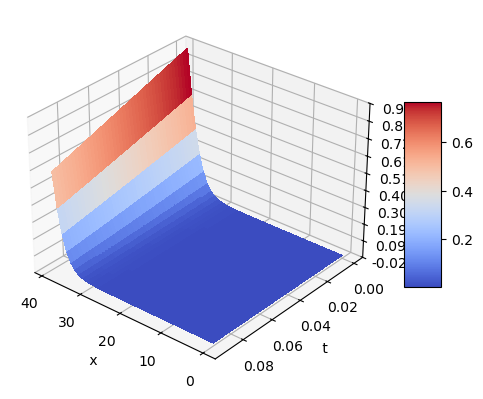

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
             
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(elev=30, azim=130)

# Set axis labels
ax.set_xlabel(" x ")
ax.set_ylabel(" t ")
ax.set_zlabel(" u(x,t) ")

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [14]:
net(x = torch.tensor([k-4]).unsqueeze(1).to(device), t = torch.tensor([T]).unsqueeze(1).to(device))

tensor([[0.0948]], grad_fn=<SoftplusBackward0>)

In [15]:
net(x = torch.tensor([37.25]).unsqueeze(1).to(device), t = torch.tensor([0.0]).unsqueeze(1).to(device))

tensor([[0.4718]], grad_fn=<SoftplusBackward0>)

In [16]:
import numpy as np
from scipy.stats import norm

N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    epsilon = 1e-8  # small number to avoid log(0) or division by 0
    S = np.maximum(S, epsilon)
    T = np.maximum(T, epsilon)
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

In [17]:
BS_CALL(S=37.25, K=k, T=T, r=r, sigma = sigma)

0.35864463742844777

In [18]:
# Save Model
#torch.save(net.state_dict(), "model_uxt.pt")

In [19]:
# Make sure t_max = T, and you're working with a call
S = ms_x
T_grid = t_max - ms_t  # time to maturity (Black-Scholes uses tau = T - t)

exact_u = BS_CALL(S, k, T_grid, r, sigma)


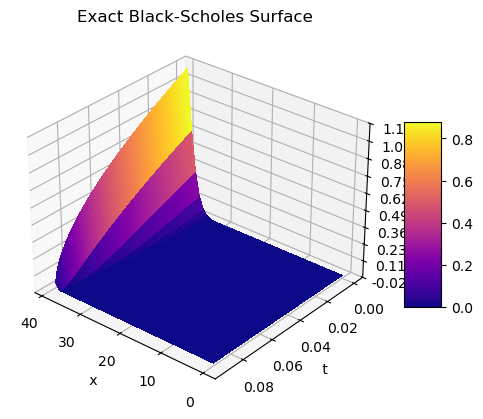

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(ms_x, ms_t, exact_u, cmap=cm.plasma, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(elev=30, azim=130)

ax.set_xlabel(" x ")
ax.set_ylabel(" t ")
ax.set_zlabel(" Exact u(x,t) ")

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Exact Black-Scholes Surface")
plt.show()


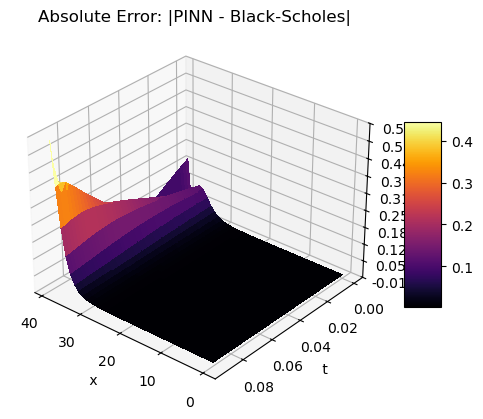

In [21]:
ms_u = np.array(ms_u, dtype=np.float32, copy=True)
exact_u = np.array(exact_u, dtype=np.float32, copy=True)

error_surface = np.abs(ms_u - exact_u)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(ms_x, ms_t, error_surface, cmap=cm.inferno, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(elev=30, azim=130)

ax.set_xlabel(" x ")
ax.set_ylabel(" t ")
ax.set_zlabel(" Absolute Error ")

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Absolute Error: |PINN - Black-Scholes|")
plt.show()
